# Practical Work: Fire Detection

In [2]:
import sys
import os
import random

import numpy as np
from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

from PIL import Image
import matplotlib.pyplot as plt

from datasets import WildfirePredictionDataset
from transformations import RandomTransformation
from models import UNet, UNetClassifier

In [4]:
# Set random seed for reproducability and dataset splitting
torch.manual_seed(42)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Exploring Data

In [6]:
# Dataset and subsets path
path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset"
train_wf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/train/wildfire"
train_nwf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/train/nowildfire"
valid_wf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/valid/wildfire"
valid_nwf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/valid/nowildfire"
test_wf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/test/wildfire"
test_nwf_path = "/home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/test/nowildfire"

In [ ]:
%%script false --no-raise-error
# Check data (corrupted images)
def check_data(path):
	files = os.listdir(path)
	for f in files:
		try:
			Image.open(os.path.join(path, f)).convert("RGB")
		except:
			print(f"{path} | {f}")

check_data(train_wf_path)
check_data(train_nwf_path)
check_data(valid_wf_path)
check_data(valid_nwf_path)
check_data(test_wf_path)
check_data(test_nwf_path)

# /home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/train/nowildfire/-114.152378,51.027198.jpg
# /home/ids/fallemand-24/ROB313/data/wildfire-prediction-dataset/test/wildfire/-73.15884,46.38819.jpg

In [10]:
# Check class balance
print(f"Train [wf]: {len(os.listdir(train_wf_path))}")
print(f"Train [nwf]: {len(os.listdir(train_nwf_path))}")
print(f"Train: {len(os.listdir(train_wf_path)) + len(os.listdir(train_nwf_path))}")
print("-" * 80)
print(f"Valid [wf]: {len(os.listdir(valid_wf_path))}")
print(f"Valid [nwf]: {len(os.listdir(valid_nwf_path))}")
print(f"Valid: {len(os.listdir(valid_wf_path)) + len(os.listdir(valid_nwf_path))}")
print("-" * 80)
print(f"Test [wf]: {len(os.listdir(test_wf_path))}")
print(f"Test [nwf]: {len(os.listdir(test_nwf_path))}")
print(f"Test: {len(os.listdir(test_wf_path)) + len(os.listdir(test_nwf_path))}")
print("-" * 80)
print(f"Total: {len(os.listdir(train_wf_path)) + len(os.listdir(train_nwf_path)) + len(os.listdir(valid_wf_path)) + len(os.listdir(valid_nwf_path)) + len(os.listdir(test_wf_path)) + len(os.listdir(test_nwf_path))}")

Train [wf]: 15750
Train [nwf]: 14499
Train: 30249
--------------------------------------------------------------------------------
Valid [wf]: 3480
Valid [nwf]: 2820
Valid: 6300
--------------------------------------------------------------------------------
Test [wf]: 3479
Test [nwf]: 2820
Test: 6299
--------------------------------------------------------------------------------
Total: 42848


In [8]:
# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Wildfire Prediction Dataset dataset
dataset = WildfirePredictionDataset(split="valid", transform=transform)
print(len(dataset))

6300


In [11]:
# Check sample sizes
sample_id = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_id]
print(img.shape)

torch.Size([3, 350, 350])


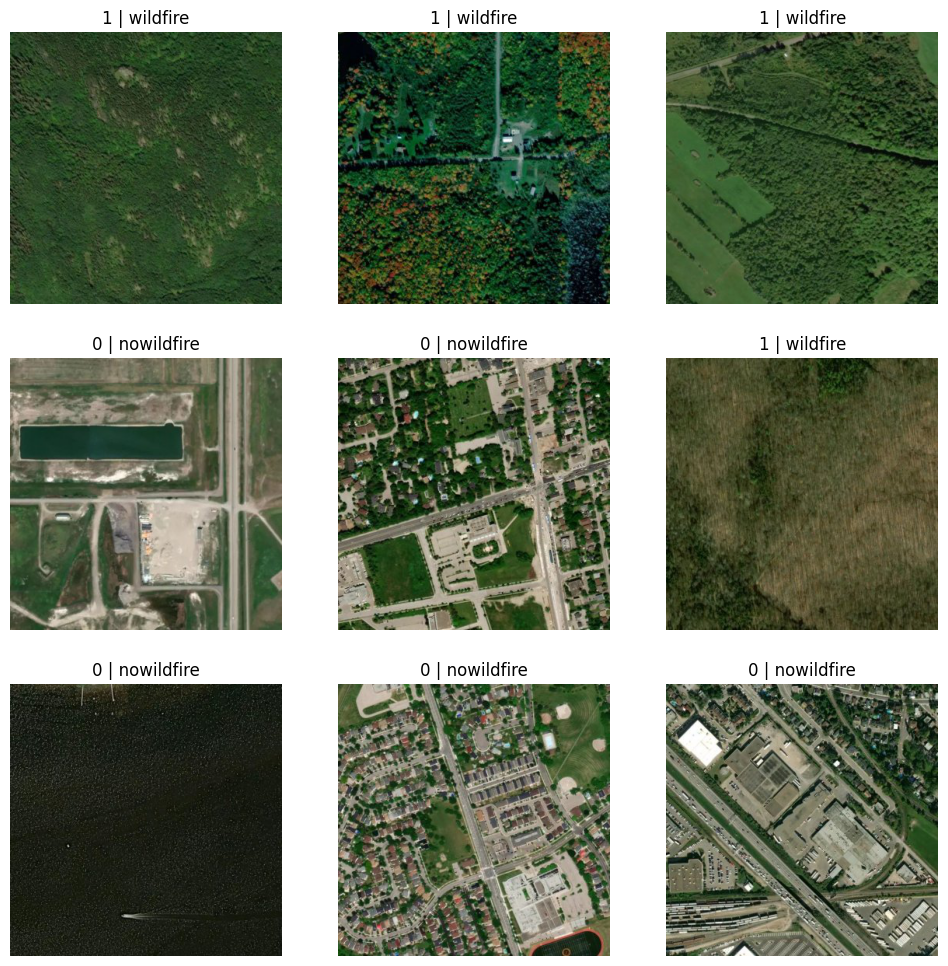

In [12]:
# %%script false --no-raise-error
# Plot images and labels
cols, rows = 3, 3
figure = plt.figure(figsize=(cols*4, rows*4))
for i in range(1, cols * rows + 1):
    sample_id = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_id]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label} | {dataset.labels_dict[label]}")
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
%%script false --no-raise-error
# Data augmentation function
random_trans = RandomTransformation((350, 350))

# Plot images and transformed images
rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
	sample_id = torch.randint(len(dataset), size=(1,)).item()
	img, label = dataset[sample_id]
	img_trans = random_trans(img)

	axs[i,0].set_title(f"{label} | {dataset.labels_dict[label]}")
	axs[i,0].axis("off")
	axs[i,0].imshow(img.permute(1, 2, 0))
	axs[i,1].axis("off")
	axs[i,1].imshow(img_trans.permute(1, 2, 0))
plt.show()

## Loading Data

In [ ]:
# Create training, validation and test data loaders
train_loader, valid_loader_1, valid_loader_2, test_loader = WildfirePredictionDataset.get_dataloaders(transform=transform, batch_size=16)

## SimCLR

### ResNet

#### Image Projection

In [ ]:
id = 285136
resnet_auto = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_auto.fc = nn.Sequential(
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Linear(256, 128),
)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
resnet_auto.load_state_dict(checkpoint["state_dict"])
resnet_auto = resnet_auto.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(resnet_auto, input_size=(3, 350, 350))

In [ ]:
batch_img, batch_label = next(iter(test_loader))
batch_out = resnet_auto(batch_img)

#### Image Classification

In [ ]:
# ResNet SL
# For baseline comparison
id = 285460 # All
id = 287649 # max_valid_2 = 0.5
id = 287992 # max_valid_2 = 0.25
id = 288476 # max_valid_2 = 0.1
resnet_sl = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_sl.fc = nn.Sequential(
	nn.Flatten(),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Linear(256, 64),
	nn.ReLU(),
	nn.Linear(64, 2),
)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
resnet_sl.load_state_dict(checkpoint["state_dict"])
resnet_sl = resnet_sl.eval().to(device)

In [ ]:
# ResNet SSL
id = 285444 # All
id = 287271 # max_valid_2 = 0.5
id = 287990 # max_valid_2 = 0.25
id = 288475 # max_valid_2 = 0.1
resnet_ssl = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_ssl.fc = nn.Sequential(
	nn.Flatten(),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Linear(256, 64),
	nn.ReLU(),
	nn.Linear(64, 2),
)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
resnet_ssl.load_state_dict(checkpoint["state_dict"])
resnet_ssl = resnet_ssl.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(resnet_ssl, input_size=(3, 350, 350))

#### GradCAM

In [ ]:
configs = [
    dict(model_type="resnet", arch=resnet_sl, layer_name="layer4"),
    dict(model_type="resnet", arch=resnet_ssl, layer_name="layer4"),
]

In [ ]:
for config in configs:
    config["arch"].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [ ]:
batch_img, batch_label = next(iter(test_loader))
nwf_idx = (batch_label == 0).nonzero().squeeze()[0].item()
wf_idx = (batch_label == 1).nonzero().squeeze()[0].item()

In [ ]:
img = batch_img[nwf_idx].unsqueeze(0)

images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(img)
    heatmap, result = visualize_cam(mask, img)

    mask_pp, _ = gradcam_pp(img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, img)
    
    images.extend([img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)
transforms.ToPILImage()(grid_image)

In [ ]:
img = batch_img[wf_idx].unsqueeze(0)

images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(img)
    heatmap, result = visualize_cam(mask, img)

    mask_pp, _ = gradcam_pp(img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, img)
    
    images.extend([img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)
transforms.ToPILImage()(grid_image)

### UNet

#### Image Reconstruction

In [ ]:
id = 285138
unet_auto = UNet()
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
unet_auto.load_state_dict(checkpoint["state_dict"])
unet_auto = unet_auto.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(unet_auto, input_size=(3, 350, 350))

In [ ]:
batch_img, batch_label = next(iter(test_loader))
batch_out = unet_auto(batch_img)

In [ ]:
# %%script false --no-raise-error
# Plot images and reconstruction
rows = 4
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
	sample_id = torch.randint(batch_img.shape[0], size=(1,)).item()
	img, label = batch_img[sample_id], batch_label[sample_id].item()
	reconstruction = batch_out["x_hat"][sample_id]
	diffs = torch.mean((reconstruction - img).abs(), dim=0).detach().cpu()

	axs[i,0].imshow(img.permute(1, 2, 0))
	axs[i,0].set_title(f"{label} | {dataset.labels_dict[label]}")
	axs[i,0].axis("off")

	axs[i,1].imshow(transforms.ToPILImage()(reconstruction.detach().cpu()))
	axs[i,2].set_title("Reconstruction")
	axs[i,1].axis("off")

	axs[i,2].imshow(diffs, cmap="viridis")
	axs[i,2].set_title("Difference")
	axs[i,2].axis("off")
    
plt.show()

#### Image Classification

In [ ]:
# UNet SL
# For baseline comparison
id = 000
unet_sl = Classifier()
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
unet_sl.load_state_dict(checkpoint["state_dict"])
unet_sl = unet_sl.eval().to(device)

In [ ]:
# UNet SSL
id = 000
unet_ssl = Classifier()
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
	weights_only=True, map_location=torch.device("cpu"))
unet_ssl.load_state_dict(checkpoint["state_dict"])
unet_ssl = unet_ssl.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(unet_ssl, input_size=(3, 350, 350))

## Create Figures for Report

Text(0.5, 0, 'Number of samples used for SL training')

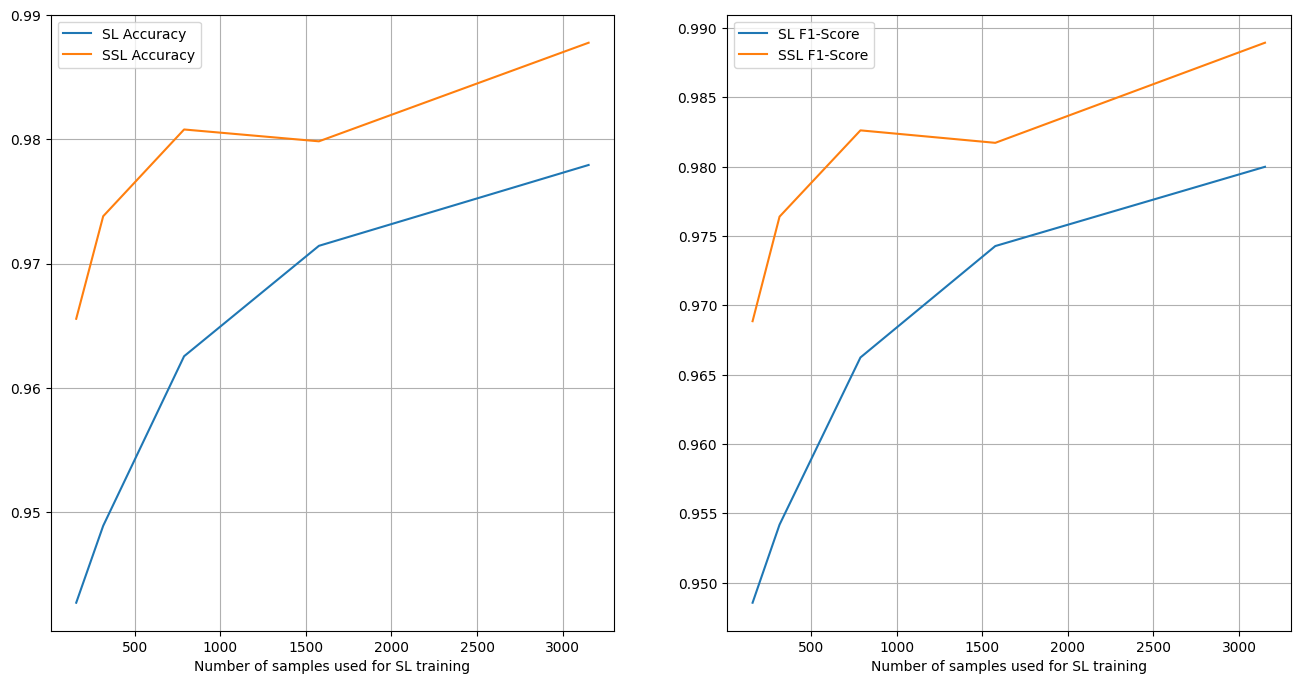

In [2]:
len_valid_loader = 197 * 16
x = [1, 0.5, 0.25, 0.1, 0.05]
x = [v * len_valid_loader for v in x]
sl_acc = [0.9779329895973206, 0.9714240431785583, 0.962533712387085, 0.9488807916641235, 0.9426892995834351]
ssl_acc = [0.9877758622169495, 0.9798380732536316, 0.9807906150817871, 0.9738053679466248, 0.9655500650405884]
sl_f1 = [0.9799913763999939, 0.9742783904075623, 0.9662471413612366, 0.9541963338851929, 0.9485681653022766]
ssl_f1 = [0.9889351725578308, 0.9817187786102295, 0.9826174378395081, 0.976398229598999, 0.9688621163368225]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].plot(x, sl_acc, label="SL Accuracy")
axs[0].plot(x, ssl_acc, label="SSL Accuracy")
axs[0].grid("on")
axs[0].legend()
axs[0].set_xlabel("Test accuracy")
axs[0].set_xlabel("Number of samples used for SL training")

axs[1].plot(x, sl_f1, label="SL F1-Score")
axs[1].plot(x, ssl_f1, label="SSL F1-Score")
axs[1].grid("on")
axs[1].legend()
axs[1].set_xlabel("Test F1-Score")
axs[1].set_xlabel("Number of samples used for SL training")

Text(0.5, 0, 'Number of samples used for SL training')

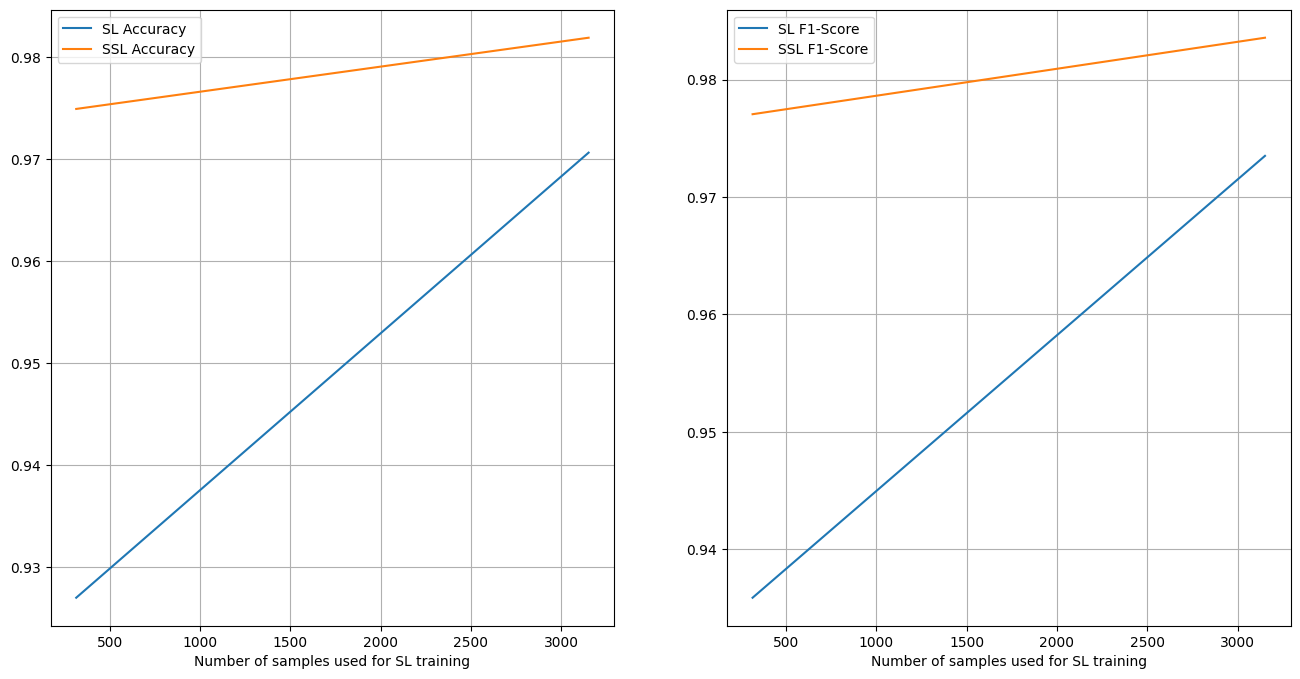

In [3]:
len_valid_loader = 197 * 16
x = [1, 0.1]
x = [v * len_valid_loader for v in x]
sl_acc = [0.9706302881240845, 0.926972508430481]
ssl_acc = [0.9819018840789795, 0.9749166369438171]
sl_f1 = [0.9735071063041687, 0.9358795881271362]
ssl_f1 = [0.9835687875747681, 0.9770548343658447]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].plot(x, sl_acc, label="SL Accuracy")
axs[0].plot(x, ssl_acc, label="SSL Accuracy")
axs[0].grid("on")
axs[0].legend()
axs[0].set_xlabel("Test accuracy")
axs[0].set_xlabel("Number of samples used for SL training")

axs[1].plot(x, sl_f1, label="SL F1-Score")
axs[1].plot(x, ssl_f1, label="SSL F1-Score")
axs[1].grid("on")
axs[1].legend()
axs[1].set_xlabel("Test F1-Score")
axs[1].set_xlabel("Number of samples used for SL training")

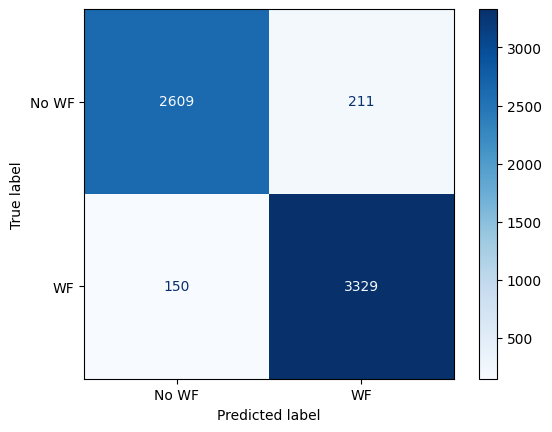

In [7]:
confusion_matrix = np.array([[2609.0, 211.0], [150.0, 3329.0]], dtype=int)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
											display_labels=["No WF", "WF"])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

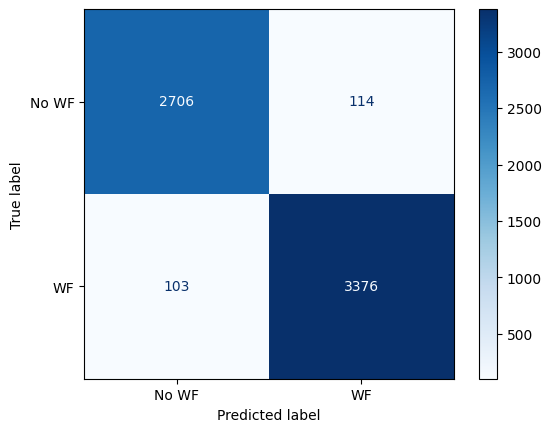

In [8]:
confusion_matrix = np.array([[2706.0, 114.0], [103.0, 3376.0]], dtype=int)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
											display_labels=["No WF", "WF"])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()